Выполнено на базе [ноутбука](https://www.kaggle.com/code/achintyatripathi/content-based-news-recomender-system)

# Imports & Configuration

In [37]:
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data preprocessing

## Load the data

In [2]:
data = pd.read_csv("./data/result_final.csv", usecols=["date", "title", "text", "link"]) \
         .drop_duplicates(inplace=False, keep="first", ignore_index=True) \
         .dropna()
data.insert(0, "id", range(0, len(data)))

print(data.shape)
display(data.head(2))

(1496, 5)


,id,link,text,title,date
0,0,http://techcrunch.com/2020/09/07/vodafone-idea...,"Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...,2020-09-07 00:00:00
1,1,http://techcrunch.com/2020/09/16/facebook-addr...,"At the beginning of the previous decade, Faceb...",Facebook addresses political controversy in In...,2020-09-16 00:00:00


## Encoding your data

Используем TF-IDF

Чистим текст

In [3]:
# функции предобработки текста
class TextCleaner:
    def __init__(self, ):
        return
    
    def __call__(self, text: str) -> str:
        # приводим к нижнему регистру
        text = self.lower_case(s=text)

        # делим на токены
        text = self.split_into_tokens(text=text)

        # удаляем стоп слова
        text = self.remove_stop_words(text=text)

        # удаляем токены, которые кроме букв содержат что-то еще
        text = self.remove_not_alpha(text=text)
        return " ".join(text)
    
    def lower_case(self, s: str) -> str:
        return s.lower()
    
    def split_into_tokens(self, text: str) -> list:
        return text.split()
    
    def remove_stop_words(self, text: list) -> list:
        return [t for t in text if not t in set(stopwords.words("english"))]
    
    def remove_not_alpha(self, text: list) -> list:
        return [t for t in text if t.isalpha()]
    

In [4]:
data["cleaned_text"] = data["text"].apply(TextCleaner())

Выолняем кодирование текста с помощью TF-IDF

In [132]:
tfidf = TfidfVectorizer(
    analyzer="word",
    stop_words="english",
    max_df=0.8, 
    min_df=0.1,
    use_idf=True,
    ngram_range=(1, 3)
)

tfidf_matrix = tfidf.fit_transform(data["cleaned_text"])

In [133]:
encoded_texts = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

print(encoded_texts.shape)
display(encoded_texts.head(3))

(1496, 188)


,able,access,according,added,adding,ahead,american,amid,announced,august,...,video,want,way,week,work,working,world,year,years,york
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.230238,0.0
1,0.056576,0.186817,0.044742,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.060684,0.053188,0.0,0.0,0.049988,0.000000,0.050178,0.0,0.000000,0.0
2,0.000000,0.345303,0.000000,0.086822,0.0,0.0,0.0,0.0,0.221197,0.0,...,0.504743,0.000000,0.0,0.0,0.000000,0.077469,0.000000,0.0,0.000000,0.0


# Data Visualization

## Метод главных компонент (PCA)

In [149]:
pca = PCA(n_components=2)
squeezed_data = pca.fit_transform(encoded_texts.values)

print(squeezed_data.shape)

(1496, 2)


<ipython-input-150-18128ee23d71>:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


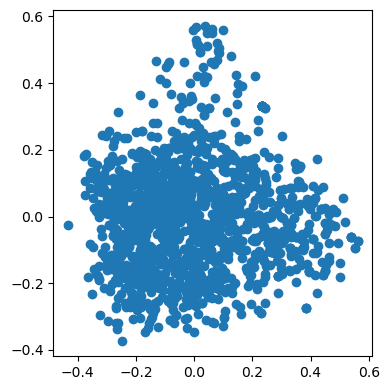

In [150]:
fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
ax.scatter(squeezed_data[:, 0], squeezed_data[:, 1])
fig.tight_layout()
fig.show()

## t-SNE

In [136]:
# Настройка функции t-SNE.
tsne = TSNE(
    n_components=2,                 # значение по умолчанию=2. Размерность вложенного пространства.

    perplexity=5,                   # значение по умолчанию=30.0. Перплексия связана с количеством 
                                    # ближайших соседей, которое используется в других алгоритмах обучения на множествах.
                                    
    early_exaggeration=12,          # значение по умолчанию=12.0. Определяет, насколько плотными будут естественные 
                                    # кластеры исходного пространстве во вложенном пространстве и сколько места будет между ними. 

    learning_rate=500,              # значение по умолчанию=200.0. Скорость обучения для t-SNE обычно находится 
                                    # в диапазоне [10.0, 1000.0]. Если скорость обучения слишком высока, данные 
                                    # могут выглядеть как "шар", в котором любая точка приблизительно равноудалена 
                                    # от ближайших соседей. Если скорость обучения слишком низкая, большинство точек 
                                    # могут быть похожими на сжатое плотное облако с незначительным количеством разбросов. 
                                    
    n_iter=10000,                   # значение по умолчанию=1000. Максимальное количество итераций для оптимизации. Должно быть не менее 250.

    n_iter_without_progress=300,    # значение по умолчанию=300. Максимальное количество итераций без прогресса перед 
                                    # прекращением оптимизации, используется после 250 начальных итераций с ранним преувеличением.

    min_grad_norm=0.0000001,        # значение по умолчанию=1e-7. Если норма градиента ниже этого порога, оптимизация будет остановлена.

    metric='euclidean',             # значение по умолчанию='euclidean', Метрика, используемая при расчете расстояния 
                                    # между экземплярами в массиве признаков.

    init='random',                  # {'random', 'pca'} или ndarray формы (n_samples, n_components), значение по 
                                    # умолчанию='random'. Инициализация вложения.

    verbose=0,                      # значение по умолчанию=0. Уровень детализации.

    random_state=42,                # экземпляр RandomState или None, по умолчанию=None. Определяет генератор случайных чисел. 
                                    # Передача int для воспроизводимых результатов при многократном вызове функции.

    method='barnes_hut',            # значение по умолчанию='barnes_hut'. По умолчанию алгоритм вычисления градиента 
                                    # использует аппроксимацию Барнса-Хата, работающую в течение времени O(NlogN). 
                                    # метод='exact' будет работать по более медленному, но точному алгоритму за время O(N^2). 
                                    # Следует использовать точный алгоритм, когда количество ошибок ближайших соседей должно быть ниже 3%.

    angle=0.5,                      # значение по умолчанию=0.5. Используется только если метод='barnes_hut' Это 
                                    # компромисс между скоростью и точностью в случае T-SNE с применением алгоритма Барнса-Хата.

    n_jobs=-1,                      # значение по умолчанию=None. Количество параллельных заданий для поиска соседей. 
                                    # -1 означает использование всех процессоров.
)

# Преобразование X
squeezed_data = tsne.fit_transform(encoded_texts.values)

print(squeezed_data.shape)

(1496, 2)


<ipython-input-137-f42569ec8464>:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


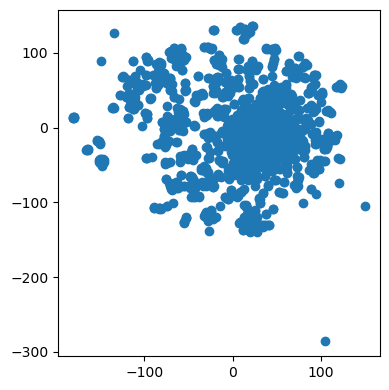

In [137]:
fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
ax.scatter(squeezed_data[:, 0], squeezed_data[:, 1])
fig.tight_layout()
fig.show();

# Переходим к рекомендациям

## Рассчитываем близость

Т.е. из всего корпуса мы посчитали близость документов (каждый с каждым)

In [138]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

print(cosine_similarities.shape)

(1496, 1496)


## Выдаем рекомендации по индексу прочтеной статьи

In [143]:
class Recomendation:
    def __init__(self, texts: list, similarity: list) -> None:
        self.texts = texts
        self.similarity = similarity
    
    def __call__(self, idx: int, n_articles: int = 5, n_sym: int = 100) -> None:
        """
        :param idx: индекс прочтеной статьи из всего корпуса текстов
        :param n_articles: количество статей, которые необходимо вывести
        """
        print(self.texts[idx][:n_sym], "...\n")

        similar_articles = \
            sorted(list(enumerate(self.similarity[idx])), key=lambda val: val[1], reverse=True)
                
        i = 0
        for idx_sim, sim in similar_articles:

            if i == n_articles:
                break
            
            if idx == idx_sim:
                continue
            
            print("ID: [{}], similarity: {:.4f}".format(idx_sim, sim))
            print(self.texts[idx_sim][:n_sym], "...\n")
            i += 1
        
        return
    

In [145]:
r = Recomendation(texts=data["text"].values, similarity=cosine_similarities)
r(idx=2, n_articles=5, n_sym=200)

As TikTok’s fate in the U.S. remains murky, YouTube today announced the launch of a new short-form video experience it’s calling YouTube Shorts. The feature will allow users, initially in India, to up ...

ID: [184], similarity: 0.5661
As it awaits its US fate, TikTok rolls out new marketing tools and Stitch to let users sample other videos

There’s a big question mark hanging over the future of TikTok right now, in the form of what ...

ID: [1033], similarity: 0.4976
If you were to ask me to read the "room" during Samsung's virtual briefing for its new Galaxy Z Fold 2, I'd say it felt weirdly tranquil. Throughout the hourlong session, the company casually breezed  ...

ID: [512], similarity: 0.4649
Facebook is getting back to its roots as a college-focused social network. The company announced today the launch of a new social networking platform, Facebook Campus, which offers college students a  ...

ID: [705], similarity: 0.4517
Beyoncé broke the internet by hopping on the remix of M